## Semantic Search with Sentence Transformers

I got guidance from [Semantic Search on sbert.net](https://www.sbert.net/examples/applications/semantic-search/README.html#) website to implement the code.

In [2]:
import torch
from langchain_community.document_loaders import PyPDFLoader
from langchain.schema import Document
from sentence_transformers import SentenceTransformer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from tqdm import tqdm
import pypdf
import random
import matplotlib.pyplot as plt

/workspace/persistent/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/persistent/venv/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA H100 PCIe
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
torch.rand(10).to(device)

tensor([0.7024, 0.2723, 0.8541, 0.5561, 0.8490, 0.0833, 0.6676, 0.2897, 0.2409,
        0.8347], device='cuda:0')

In [4]:
path_to_pdf: str = '../data/rag_report.pdf'

loader = PyPDFLoader(path_to_pdf)
dataset: list[Document] = loader.load()

dataset[0:5]

[Document(metadata={'source': '../data/rag_report.pdf', 'page': 0, 'page_label': '1'}, page_content='  \n  \n \n'),
 Document(metadata={'source': '../data/rag_report.pdf', 'page': 1, 'page_label': '2'}, page_content=' \n1 \nDear shareholders, colleagues, customers, and partners: \nFiscal year 2024 was a pivotal year for Microsoft. We entered our 50th year as a company and the second year of the AI \nplatform shift. With these milestones, I’ve found myself reflecting on how Microsoft has remained a consequential company \ndecade after decade in an industry with no franchise value. And I realize that it’s because—time and time again, when tech \nparadigms have shifted —we have seized the opportunity to reinvent ourselves to stay relevant to our customers, our \npartners, and our employees. And that’s what we are doing again today.  \nMicrosoft has been a platform and tools company from the start. We were founded in 1975 with a belief in creating \ntechnology that would enable others to c

In [5]:
[func for func in list(dir(dataset[0])) if func[0] != '_' ]

['cast_id_to_str',
 'construct',
 'copy',
 'dict',
 'from_orm',
 'get_lc_namespace',
 'id',
 'is_lc_serializable',
 'json',
 'lc_attributes',
 'lc_id',
 'lc_secrets',
 'metadata',
 'model_computed_fields',
 'model_config',
 'model_construct',
 'model_copy',
 'model_dump',
 'model_dump_json',
 'model_extra',
 'model_fields',
 'model_fields_set',
 'model_json_schema',
 'model_parametrized_name',
 'model_post_init',
 'model_rebuild',
 'model_validate',
 'model_validate_json',
 'model_validate_strings',
 'page_content',
 'parse_file',
 'parse_obj',
 'parse_raw',
 'schema',
 'schema_json',
 'to_json',
 'to_json_not_implemented',
 'type',
 'update_forward_refs',
 'validate']

In [6]:
dataset[2].page_content

' \n2 \nreasoning and planning capabilities that help us understand complex context, complete end-to-end tasks on our behalf, and \nreduce our cognitive load.  \nThis new world is being defined by a rich tapestry of AI agents, which can take action on our behalf, including personal \nagents across work and life, business process agents, and cross-organizational ones. These agents will be able to work in \nconcert as a new input to help make small businesses more productive, make multinationals more competitive, make the \npublic sector more efficient, and improve health and education outcomes broadly.  \nMicrosoft has built three leading platforms to help our customers maximize their opportunity in this emerging agentic era: \nCopilot, which you can think of as the new UI for AI —the human interface for this agentic world; the Copilot stack, which \nbrings together infrastructure, data, and app services to help customers build their own copilots and agents for their own \nbusiness proc

In [7]:
print(len(dataset))

91


In [8]:
text_splitter: RecursiveCharacterTextSplitter = RecursiveCharacterTextSplitter(
    separators=['\n', '\n\n', '  \n'],
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_documents(dataset)

print([len(c.page_content) for c in chunks])
len(chunks)

[425, 429, 480, 465, 437, 413, 376, 423, 419, 442, 116, 398, 447, 423, 427, 441, 399, 483, 391, 486, 417, 476, 409, 397, 376, 378, 458, 479, 465, 440, 312, 400, 381, 483, 424, 395, 476, 397, 450, 389, 465, 417, 445, 492, 383, 457, 455, 380, 458, 485, 176, 410, 392, 491, 451, 380, 426, 446, 396, 470, 445, 399, 392, 490, 450, 404, 381, 418, 451, 400, 444, 460, 453, 424, 455, 467, 463, 144, 406, 181, 408, 378, 385, 496, 408, 480, 446, 397, 498, 20, 450, 456, 459, 461, 493, 480, 406, 477, 400, 420, 429, 441, 451, 398, 488, 412, 485, 455, 481, 385, 408, 246, 388, 417, 456, 449, 496, 394, 453, 425, 397, 154, 437, 399, 417, 477, 485, 373, 377, 438, 443, 417, 414, 396, 484, 480, 487, 420, 455, 384, 496, 436, 426, 204, 388, 443, 480, 390, 493, 476, 490, 481, 468, 476, 469, 378, 456, 459, 493, 400, 398, 477, 479, 476, 358, 480, 491, 487, 447, 419, 424, 433, 494, 480, 474, 232, 454, 471, 464, 466, 455, 413, 495, 383, 187, 480, 480, 489, 395, 447, 430, 462, 430, 490, 388, 398, 219, 415, 420, 446, 

701

In [17]:
embedder: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2')

In [18]:
embeddings = embedder.encode([chunk.page_content for chunk in tqdm(chunks)], convert_to_tensor=True)

100%|██████████| 701/701 [00:00<00:00, 1176553.46it/s]


In [19]:
embeddings

tensor([[-0.0179, -0.0291,  0.0634,  ..., -0.0246,  0.0182, -0.0358],
        [-0.0287, -0.0547, -0.0223,  ..., -0.0414,  0.0929, -0.0361],
        [-0.0453, -0.0370, -0.0447,  ..., -0.0506, -0.0359, -0.0705],
        ...,
        [ 0.0051, -0.0209,  0.0684,  ..., -0.0483,  0.0493, -0.0351],
        [ 0.0443, -0.0411,  0.0298,  ...,  0.0196, -0.0065, -0.0686],
        [ 0.0265, -0.0005,  0.0089,  ..., -0.0294,  0.0421,  0.0412]],
       device='cuda:0')

In [20]:
queries = [
    'What is Microsoft\'s strategy for cloud computing in the next five years?',
    'How does Microsoft plan to innovate in the field of artificial intelligence?',
    'What are Microsoft\'s future plans for the Windows operating system?',
    'How will Microsoft enhance its cybersecurity measures in the coming years?',
    'What new features can we expect in future versions of Microsoft Office?',
    'What is Microsoft\'s vision for the future of remote work and collaboration tools?',
    'How does Microsoft plan to expand its gaming division, including Xbox and Game Pass?',
    'What are Microsoft\'s goals for sustainability and reducing its carbon footprint?',
    'How will Microsoft integrate emerging technologies like quantum computing into its products?',
    'What partnerships and acquisitions is Microsoft planning to strengthen its market position?'
]

In [21]:
query = queries[random.randint(0, len(queries))]

k = 3

query_embedding = embedder.encode(query, convert_to_tensor=True)

similarity_scores = embedder.similarity(query_embedding, embeddings)[0]
scores, indices = torch.topk(similarity_scores, k=k)

print(f'\nQuery: {query}')
print(f'Top {k} most similar sentences in corpus:\n')

for score, idx in zip(scores, indices):
    print(f'\n{chunks[idx].page_content} (Score: {score:.4f}, Index: {idx})\n')


Query: What are Microsoft's future plans for the Windows operating system?
Top 3 most similar sentences in corpus:


achieve more for the long term.  
It is not an exaggeration to say that what each of us does right now with the unique opportunity we have been given will 
shape the future. And I look forward to seeing how all of us use Microsoft as a platform to make a difference—one customer, 
one community, one country at a time.  
  
  
 
Satya Nadella  
Chairman and Chief Executive Officer  
October 18, 2024 (Score: 0.6434, Index: 69)


operate—for granted. It is something we must earn.  
We always say Microsoft will do well only if the world around us does well. And that’s why we are focused on four enduring 
commitments. They keep us grounded, serving as a guide as we make decisions, pushing us to ask critical questions to 
ensure the technology we create benefits everyone on the planet, as well as the planet itself. (Score: 0.6284, Index: 39)


19 
Windows  
The Windows operati

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

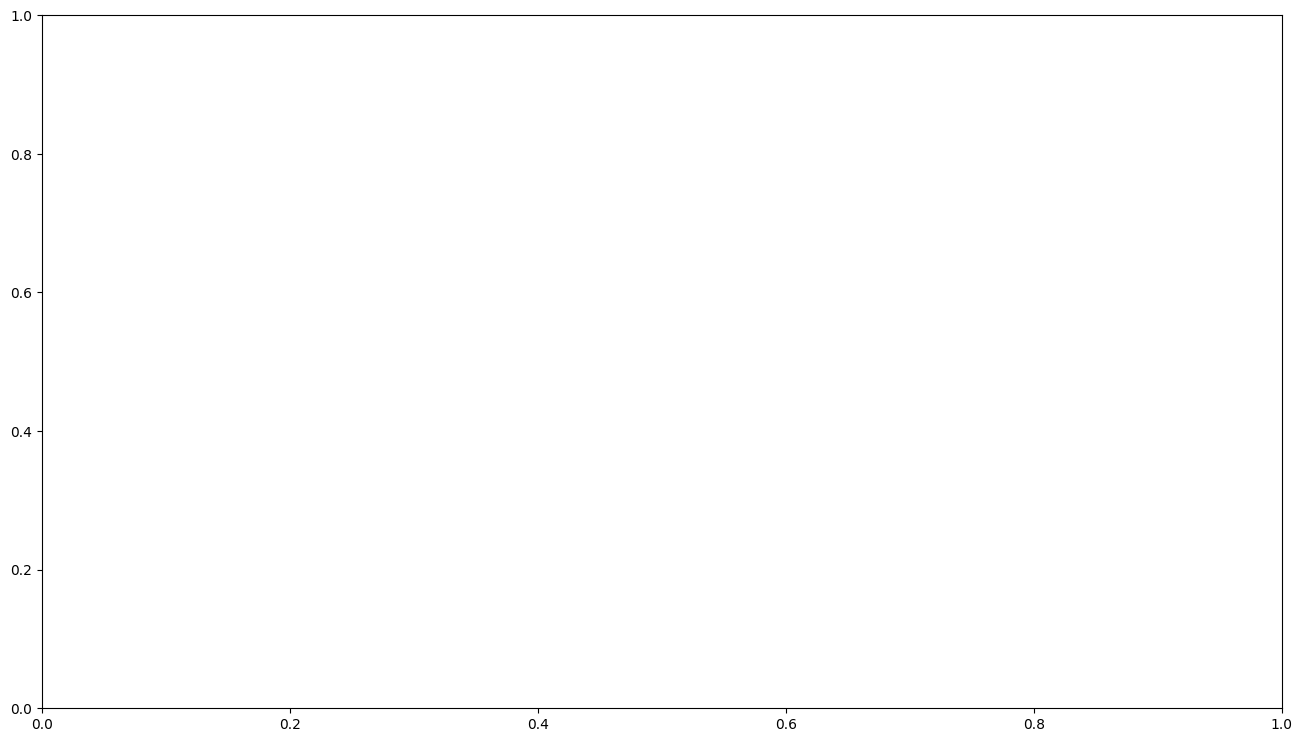

In [22]:
plt.figure(figsize=(16,9))
plt.bar(range(len(similarity_scores)), similarity_scores, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Document Index')
plt.title('Sentence Similarities')
plt.show()

In [ ]:
top_k = 3

for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    similarity_scores = embedder.similarity(query_embedding, embeddings)[0]
    scores, indices = torch.topk(similarity_scores, k=top_k)

    print(f'\nQuery: {query}')
    print(f'Top {k} most similar sentences in corpus:\n')

    for score, idx in zip(scores, indices):
        print(f'\n{chunks[idx].page_content} (Score: {score:.4f}, Index: {idx})\n')